In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model

### Taking reference from https://medium.com/@vijendra1125/ocr-part-2-ocr-using-cnn-f43f0cee8016 and https://github.com/SIDD58/Captcha-recognition-using-CNN

### The idea behind the model is to construct a cnn model which extracts all the important features and after flattening connects to 5 separate sets of nn each corresponding to a letter in the captcha

In [50]:
# importing the images in the shape required by tensorflow

X = np.zeros((1070,50,200,1))
for i in range(1,1071): 
    image=np.reshape(np.array(tf.keras.utils.load_img(f'{i}.png',color_mode='grayscale',target_size=(50,200))),(50,200,1))/255
    
    X[i-1,:,:,:]=image
    

In [51]:
# importing the dataset and correcting it

target=pd.read_csv('C:\\Users\\manas\\OneDrive\\Desktop\\bsc secy task\\CaptchaDataset\\dataset1\\mapping.csv')
target['captcha'][17]="3bfnd"

#### We will one hot encode into a 5*1070*36 matrix in which 5 corresponds to the number of letters,1070 is number of data points and 36 is the number of possible charaters with 0-9 being 0-9 and a-z being 10-35

In [52]:
# one hot encoding the captcha for each of the 5 letters

def hot_encode(labels):
    encoded = np.zeros((5, 1070, 36), dtype=np.float32)
    for i, label in enumerate(labels):
        for j, char in enumerate(label):
            if ord(char)<80:
                encoded[j,i ,ord(char) - 48] = 1
            else:
                encoded[j,i ,ord(char)-87] = 1
    return encoded

y = hot_encode(target['captcha'])

In [53]:
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [54]:
input = layers.Input(shape=(50,200,1))
conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(input) #50*200
m_pool1 = layers.MaxPooling2D( padding='same')(conv1)  
conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(m_pool1)
m_pool2 = layers.MaxPooling2D( padding='same')(conv2)  
conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(m_pool2)
bn = layers.BatchNormalization()(conv3)
m_pool3 = layers.MaxPooling2D( padding='same')(bn)  
    
flatten = layers.Flatten()(m_pool3) 

# connections the 5 different nn mentioned above
output = []
for _ in range(5): 
    dense1 = layers.Dense(64, activation='relu')(flatten)
    dropout = layers.Dropout(0.5)(dense1)
    output_each = layers.Dense(36, activation='sigmoid')(dropout)

    output.append(output_each)
    


In [55]:
model=Model(input, output);
model.compile( optimizer='adam',loss='categorical_crossentropy')
model.summary();

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 50, 200, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 50, 200, 16)       │             160 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 25, 100, 16)       │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 25, 100, 32)       │           4,640 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 13, 50, 32)        │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 13, 50, 32)        │           9,248 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 13, 50, 32)        │             128 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 7, 25, 32)         │               0 │ batch_normalization_2[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 5600)              │               0 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 64)                │         358,464 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 64)                │         358,464 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_24 (Dense)              │ (None, 64)                │         358,464 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_26 (Dense)              │ (None, 64)                │         358,464 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_28 (Dense)              │ (None, 64)                │         358,464 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 64)                │               0 │ dense_20[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,818,196 (6.94 MB)

 Trainable params: 1,818,132 (6.94 MB)

 Non-trainable params: 64 (256.00 B)

In [56]:
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], epochs=70, validation_split=0.2)

Epoch 1/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - loss: 19.4625 - val_loss: 17.6971
Epoch 2/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - loss: 17.3287 - val_loss: 17.4814
Epoch 3/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 16.6399 - val_loss: 17.3714
Epoch 4/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 15.7931 - val_loss: 17.0509
Epoch 5/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - loss: 15.2927 - val_loss: 17.0450
Epoch 6/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - loss: 14.5143 - val_loss: 16.7478
Epoch 7/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - loss: 13.8093 - val_loss: 16.5009
Epoch 8/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - loss: 12.9732 - val_loss: 16.0387
Epoch 9/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - loss: 12.5532 - val_loss: 15.5289
Epoch 10/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 11.6755 - val_loss: 14.3020
Epoch 11/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 11.2514 - val_loss: 13.9931
Epoch 12/70
25/25 ━━━━━━━━

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 1.7200 - val_loss: 2.4794
Epoch 69/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 1.8870 - val_loss: 2.3779
Epoch 70/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 1.7579 - val_loss: 2.6895


In [57]:
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4245


1.1325923204421997

In [58]:
preds=np.array(model.predict(X_test))

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/stepWARNING:tensorflow:5 out of the last 20 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001DCADECA200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


In [59]:
# converting the one hot encode back to letters and numbers

pred=[]
for i in range(100):
    temp=[]
    hey=np.argmax(preds[:,i,:],axis=1)
    for j in range(5):
        if hey[j]<=9:
            temp.append(str(hey[j]))
        else:
            temp.append(chr(hey[j]+87))
    pred.append(temp)
#     pred[i,:]=hey

In [60]:
print(pred[0])

['5', '7', '3', 'b', '8']


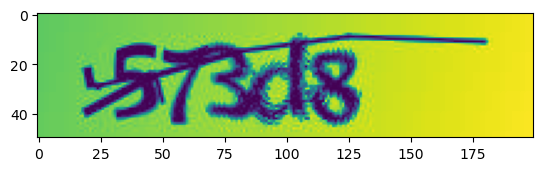

In [61]:
plt.imshow(X_test[0])

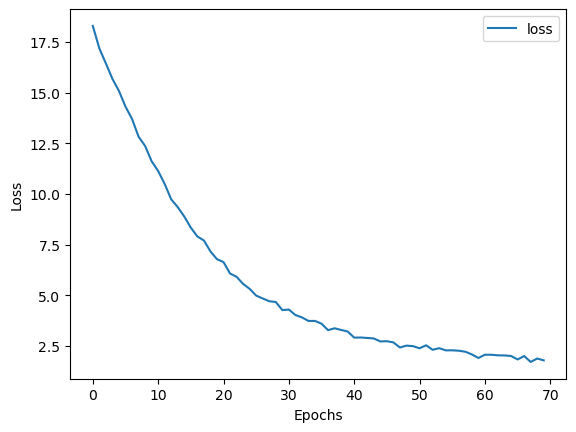

In [62]:
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

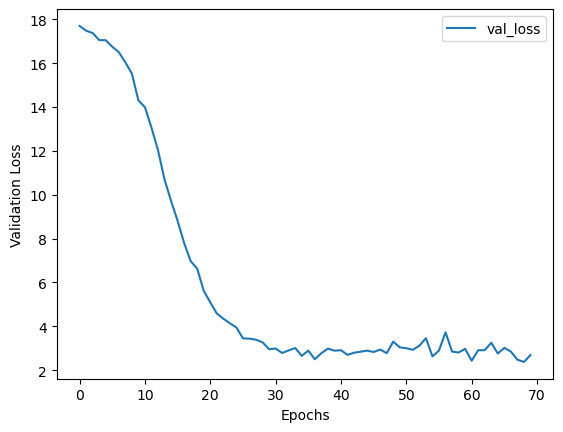

In [63]:
for label in ["val_loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

In [64]:
def print_captcha(file):
    image=np.reshape(np.array(tf.keras.utils.load_img(file,color_mode='grayscale',target_size=(50,200))),(50,200,1))/255
    X = np.zeros((1,50,200,1))
    X[0,:,:,:]=image
    preds=np.array(model.predict(X))
    
    

    temp=""
    hey=np.argmax(preds[:,0,:],axis=1)
    for j in range(5):
        if hey[j]<=9:
            temp+=(str(hey[j]))
        else:
            temp+=(chr(hey[j]+87))
    plt.imshow(image)
    plt.title(temp)
    plt.axis("off")
    

### Please enter the input file name and directory below

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


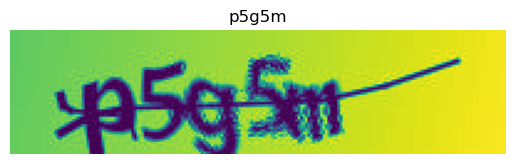

In [65]:
# please enter the test image location
file_location="1.png"


print_captcha(file_location)